## Script que faz clustering com DBSCAN

# DBSCAN: Clustering Baseado em Densidade

O **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** é um algoritmo de agrupamento não supervisionado que identifica clusters com base na densidade dos dados, sem a necessidade de especificar previamente o número de grupos. Ele classifica pontos como pertencentes a um cluster, ruído ou borda, dependendo de sua proximidade a outros pontos em áreas de alta densidade. 

Ideal para lidar com formas de clusters arbitrárias e dados com ruídos, o DBSCAN é amplamente utilizado em **análise geoespacial**, **segmentação de imagens**, **classificação de texto baseada em embeddings** e **detecção de anomalias**. No caso de **classificação de texto**, o DBSCAN pode ser usado para agrupar documentos semelhantes a partir de vetores gerados por modelos de embeddings como Word2Vec, GloVe ou transformers, permitindo a descoberta de tópicos ou agrupamentos de textos sem rótulos prévios.

Sua principal limitação é a sensibilidade à escolha dos parâmetros de densidade, como o raio de vizinhança (**ε**) e o número mínimo de pontos.

Este script irá testar diferentes números de clusters para identificar a quantidade que gera a melhor **compactação**, **separação** e **coerência** dos grupos formados. A avaliação será realizada utilizando as métricas:

- **Silhouette Score:** Mede a compactação dentro dos clusters e a separação entre clusters.
- **Davies-Bouldin Score:** Avalia a relação entre a dispersão dentro dos clusters e a separação entre clusters (valores menores indicam melhor qualidade).
- **Calinski-Harabasz Score:** Mede a proporção entre a variância entre clusters e dentro dos clusters (valores maiores indicam melhor qualidade).

Também será havaliado:
- **Proporção de ruído**: Portarias que não foram possíveis classificar
- **Total de clustar válidos gerados**

Adicionalmente, o teste levará em consideração:
- A análise com o texto original e o texto tratado.
- A aplicação de métodos de redução de dimensionalidade para otimizar os dados.

---

**1)** Execução Inicial:
O script inicia com a leitura do arquivo:  
**`f'./saida/06_1_DOU2_portarias_mgi_tratado_NER_lematizado_embeddingsUSE_SBERT_Reducao_Kmeans.parquet'`**  
Caso este arquivo não exista, executar o notebook **`06_2_Clustering_DBSCAN.ipynb`** para gerar os dados necessários.



## Bibliotecas

In [1]:
# Bibliotecas para manipulação de dados e cálculo
import pandas as pd
import numpy as np
import time  # Para medir o tempo de execução

# Bibliotecas para visualização
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Bibliotecas para clusterização
from sklearn.cluster import DBSCAN

# Bibliotecas de aprendizado de máquina e redução de dimensionalidade
from sklearn.decomposition import PCA, KernelPCA
# from sklearn.manifold import TSNE, LocallyLinearEmbedding
# from sklearn.preprocessing import StandardScaler
# import umap

# Métricas para avaliação de clusters
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Hierarquia para dendrogramas
from scipy.cluster.hierarchy import dendrogram, linkage



In [2]:
douItem = 2
secao = f'Secao0{douItem}'

# Lê o arquivo Parquet
df_portarias_mgi = pd.read_parquet(f'./saida/06_1_DOU{secao}_portarias_mgi_tratado_NER_lematizado_embeddingsUSE_SBERT_Reducao_Kmeans.parquet', engine='pyarrow')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df_portarias_mgi.shape


(19258, 83)

In [3]:
df_portarias_mgi.head()

id                             name idOficio pubName   artType  \
0  30266027          PORTARIA DE PESSOAL 529  9368436     DO2  Portaria   
1  30264410                 ATO PORTARIA 655  9368530     DO2  Portaria   
2  30265009      ATO PORTARIA DE PESSOAL 461  9368536     DO2  Portaria   
3  30265678  ATO PORTARIA DE PESSOAL SGP 606  9368541     DO2  Portaria   
4  30266030  ATO PORTARIA DE PESSOAL SGP 517  9368573     DO2  Portaria   

     pubDate                                           artClass  \
0 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
1 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
2 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
3 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
4 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   

                                         artCategory artSize artNotes  ...  \
0  Ministério da Gestão e da Inovação em Serviços...      12           ...   
1  Ministério da Gestão e da Inovação em Serviços...      12           ...   
2  Ministério da Gestão e da Inovação em Serviços...      12           ...   
3  Ministério da Gestão e da Inovação em Serviços...      12           ...   
4  Ministério da Gestão e da Inovação em Serviços...      12           ...   

  SBERT_Embeddings1_kmeans SBERT_Embeddings1_PCA_kmeans  \
0                        2                            0   
1                        2                            0   
2                        2                            0   
3                        0                            2   
4                        2                            0   

  SBERT_Embeddings1_TSNE_kmeans SBERT_Embeddings1_PCA_TSNE_kmeans  \
0                             3                                 5   
1                             4                                 5   
2                             4                                 6   
3                             7                                 6   
4                             7                                 4   

  SBERT_Embeddings1_UMAP_kmeans SBERT_Embeddings4_kmeans  \
0                             2                        0   
1                             1                        0   
2                             1                        0   
3                             2                        1   
4                             2                        0   

  SBERT_Embeddings4_PCA_kmeans SBERT_Embeddings4_TSNE_kmeans  \
0                            1                             4   
1                            0                             1   
2                            0                             1   
3                            1                             3   
4                            0                             3   

  SBERT_Embeddings4_PCA_TSNE_kmeans SBERT_Embeddings4_UMAP_kmeans  
0                                 4                             5  
1                                 4                             5  
2                                 4                             5  
3                                 3                             7  
4                                 3                             7  

[5 rows x 83 columns]

In [4]:
df_portarias_mgi.columns

Index(['id', 'name', 'idOficio', 'pubName', 'artType', 'pubDate', 'artClass',
       'artCategory', 'artSize', 'artNotes', 'numberPage', 'pdfPage',
       'editionNumber', 'highlightType', 'highlightPriority', 'highlight',
       'highlightimage', 'highlightimagename', 'idMateria', 'Identifica',
       'Data', 'Ementa', 'Titulo', 'SubTitulo', 'TextoHTML', 'file_name',
       'zip_name', 'Ano', 'Mes', 'Texto', 'Total_palavras', 'TextoTratado',
       'TextoTratado_TotalPalavras', 'Texto_sem_nomes', 'Nomes',
       'TextoTratadoSemNomes', 'TextoTratadoSemNomes_TotalPalavras',
       'TextoTratadoSemNomesLemmatized',
       'TextoTratadoSemNomesLemmatized_TotalPalavras', 'USE_Embeddings1',
       'USE_Embeddings4', 'SBERT_Embeddings1', 'SBERT_Embeddings4',
       'USE_Embeddings1_PCA', 'USE_Embeddings4_PCA', 'SBERT_Embeddings1_PCA',
       'SBERT_Embeddings4_PCA', 'USE_Embeddings1_TSNE', 'USE_Embeddings4_TSNE',
       'SBERT_Embeddings1_TSNE', 'SBERT_Embeddings4_TSNE',
       'USE_Embeddi

## Funções

In [5]:
def escolher_melhor_configuracao_dbscan(df_resultados):
    """
    Identifica a melhor configuração de DBSCAN com base nas métricas Silhouette, Davies-Bouldin,
    Calinski-Harabasz e no percentual de ruído, priorizando configurações com menor ruído.

    Parâmetros:
        df_resultados (pd.DataFrame): DataFrame contendo as métricas para diferentes combinações de parâmetros.
    
    Retorno:
        pd.Series: Linha do DataFrame correspondente à melhor configuração.
    """
    # Cópias temporárias das colunas relevantes
    silhouette = df_resultados['Silhouette Score']
    davies_bouldin = df_resultados['Davies-Bouldin Score']
    calinski_harabasz = df_resultados['Calinski-Harabasz Score']

    # Normalizar as métricas
    silhouette_norm = silhouette / silhouette.max()
    davies_bouldin_norm = davies_bouldin.min() / davies_bouldin
    calinski_harabasz_norm = calinski_harabasz / calinski_harabasz.max()

    # Critério de avaliação: soma ponderada
    df_resultados['Score Geral'] = silhouette_norm + davies_bouldin_norm + calinski_harabasz_norm

    # Ordenar pelo Score Geral e, em caso de empate, pelo menor ruído
    df_ordenado = df_resultados.sort_values(by=['Score Geral', 'ruido_percent'], ascending=[False, True])

    # Retornar a melhor configuração
    melhor_configuracao = df_ordenado.iloc[0]

    return melhor_configuracao


In [16]:
def clusterizar_e_plotar_dbscan_tsne(df, embeddings_2d, eps, min_samples, varEmbedding="Embeddings", sufixo_grafico=""):
    """
    Aplica o DBSCAN em dados reduzidos (ex.: t-SNE), exibe métricas de avaliação e gera o gráfico de clusters.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados originais.
        embeddings_2d (np.ndarray): Dados reduzidos para 2 dimensões (ex.: t-SNE ou PCA).
        eps (float): Valor do parâmetro eps para o DBSCAN.
        min_samples (int): Valor do parâmetro min_samples para o DBSCAN.
        varEmbedding (str): Nome descritivo para os embeddings, usado no título do gráfico.
        sufixo_grafico (str): Sufixo a ser incluído no título do gráfico, se fornecido.

    Retorno:
        pd.DataFrame: DataFrame atualizado com os clusters atribuídos pelo DBSCAN.
    """
    # Aplicação do DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(embeddings_2d)

    # Adicionar clusters ao DataFrame
    cluster_column_name = f"Cluster_tnse_dbscan_{varEmbedding}"
    df[cluster_column_name] = clusters

    # Calcular métricas de avaliação para clusters válidos
    mask_valid_clusters = clusters != -1
    valid_embeddings = embeddings_2d[mask_valid_clusters]
    valid_clusters = clusters[mask_valid_clusters]
    
    if len(set(valid_clusters)) > 1:  # Apenas se houver mais de um cluster válido
        silhouette = silhouette_score(valid_embeddings, valid_clusters)
        davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
        calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
    else:
        silhouette = davies_bouldin = calinski_harabasz = np.nan

    print("\n--- Métricas de Avaliação ---")
    print(f"Silhouette Score: {silhouette:.6f}" if not np.isnan(silhouette) else "Silhouette Score: Não aplicável")
    print(f"Davies-Bouldin Score: {davies_bouldin:.6f}" if not np.isnan(davies_bouldin) else "Davies-Bouldin Score: Não aplicável")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.6f}" if not np.isnan(calinski_harabasz) else "Calinski-Harabasz Score: Não aplicável")
    print(f"Proporção de ruído: {(np.sum(clusters == -1) / len(clusters)) * 100:.2f}%")
    print("-----------------------------\n")

    # Gerar gráfico
    print("Gerando gráfico 2D...")
    plt.figure(figsize=(10, 6))
    unique_clusters = set(clusters)
    for cluster in unique_clusters:
        cluster_points = embeddings_2d[clusters == cluster]
        color = 'gray' if cluster == -1 else None
        label = 'Ruído' if cluster == -1 else f'Cluster {cluster}'
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=label, s=10, cmap='viridis', alpha=0.7, c=color)
    
    plt.xlabel("Dimensão 1")
    plt.ylabel("Dimensão 2")
    grafico_titulo = f"Clusters com t-SNE + DBSCAN (eps={eps}, min_samples={min_samples})"
    if sufixo_grafico:
        grafico_titulo += f" - {sufixo_grafico}"
    plt.title(grafico_titulo)
    plt.legend(loc='best', markerscale=1.5)
    plt.grid(True)
    plt.colorbar(label="Cluster")
    plt.show()

    return df


In [13]:
def processar_dbscan_e_clusterizar(df, coluna_embeddings, eps_values, min_samples_values):
    """
    Processa o DBSCAN para várias combinações de parâmetros, identifica a melhor configuração,
    realiza a clusterização e gera a visualização.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna_embeddings (str): Nome da coluna do DataFrame com os embeddings a serem clusterizados.
        eps_values (list): Lista de valores de eps a serem testados.
        min_samples_values (list): Lista de valores de min_samples a serem testados.

    Retorno:
        pd.DataFrame: DataFrame atualizado com a clusterização da melhor configuração.
    """
    # Gerar combinações de DBSCAN e coletar métricas
    print("Iniciando o processamento para várias combinações de eps e min_samples...")
    df_resultados = []
    
    embeddings = np.vstack(df[coluna_embeddings])
    for eps in eps_values:
        for min_samples in min_samples_values:
            print(f"Processando DBSCAN para eps={eps}, min_samples={min_samples}...")
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
            clusters = dbscan.fit_predict(embeddings)

            # Filtrar clusters válidos
            mask_valid_clusters = clusters != -1
            valid_embeddings = embeddings[mask_valid_clusters]
            valid_clusters = clusters[mask_valid_clusters]

            # Calcular métricas se houver mais de um cluster válido
            if len(set(valid_clusters)) > 1:
                silhouette = silhouette_score(valid_embeddings, valid_clusters)
                davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
                calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
            else:
                silhouette = davies_bouldin = calinski_harabasz = np.nan

            # Calcular proporção de ruído
            num_points = len(clusters)
            num_noise = np.sum(clusters == -1)
            noise_ratio = (num_noise / num_points) * 100  # Em percentual

            # Armazenar resultados
            df_resultados.append({
                'eps': eps,
                'min_samples': min_samples,
                'Silhouette Score': silhouette,
                'Davies-Bouldin Score': davies_bouldin,
                'Calinski-Harabasz Score': calinski_harabasz,
                'ruido_percent': round(noise_ratio, 2),
                'clusters_validos': len(set(valid_clusters)) - (1 if -1 in clusters else 0)
            })

    # Converter resultados para DataFrame
    df_resultados = pd.DataFrame(df_resultados)
    
    # Encontrar a melhor configuração
    print("\nAvaliando a melhor configuração de DBSCAN...")
    melhor_configuracao = escolher_melhor_configuracao_dbscan(df_resultados)
    if melhor_configuracao is None:
        print("Nenhuma configuração válida encontrada. Finalizando.")
        return df

    print("Melhor configuração encontrada:")
    print(melhor_configuracao)

    # Realizar clusterização e plotagem com a melhor configuração
    eps = melhor_configuracao['eps']
    min_samples = melhor_configuracao['min_samples']
    df = clusterizar_e_plotar_dbscan(df, coluna_embeddings, eps, int(min_samples), sufixo_coluna="dbscan", sufixo_grafico="Melhor Configuração")

    return df_resultados


## 1) Embedding Universal Sentence Encoder (USE)

###  1.1) Sem tratamento do texto

#### 1.1.1) Sem redução de dimensionalidade

Iniciando o processamento para várias combinações de eps e min_samples...
Processando DBSCAN para eps=0.3, min_samples=5...

Avaliando a melhor configuração de DBSCAN...
Melhor configuração encontrada:
eps                          0.300000
min_samples                  5.000000
Silhouette Score             0.034222
Davies-Bouldin Score         1.398406
Calinski-Harabasz Score    146.498672
ruido_percent                6.040000
clusters_validos            46.000000
Score Geral                  3.000000
Name: 0, dtype: float64
Reduzindo as dimensões para 2 com PCA para visualização (original: 512 dimensões)...

--- Métricas de Avaliação ---
Silhouette Score: Não aplicável
Davies-Bouldin Score: Não aplicável
Calinski-Harabasz Score: Não aplicável
Proporção de ruído: 0.00%
-----------------------------

Gerando gráfico dos clusters...


C:\Users\aqcor\AppData\Local\Temp\ipykernel_21988\1916621942.py:64: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=label, s=10, cmap='viridis', alpha=0.7, c=color)


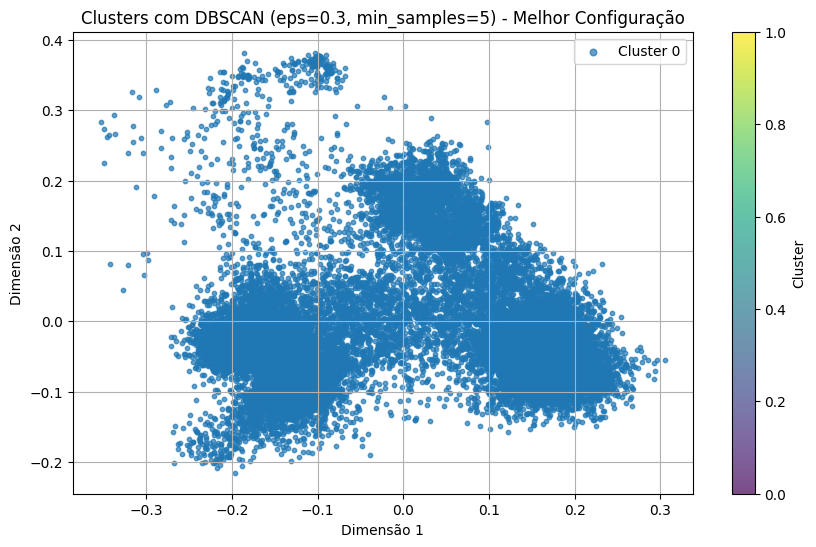

eps  min_samples  Silhouette Score  Davies-Bouldin Score  \
0  0.3            5          0.034222              1.398406   

   Calinski-Harabasz Score  ruido_percent  clusters_validos  Score Geral  
0               146.498672           6.04                46          3.0

In [15]:
resultado_dbscan = processar_dbscan_e_clusterizar(df_portarias_mgi, 'USE_Embeddings1', eps_values = [0.3], min_samples_values = [5])

# Exibir os resultados
resultado_dbscan.head(100)

#### 1.1.2) Redução com PCA

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings1_PCA', k_min=2, k_max=10, sufixo_grafico="PCA")

# Exibir os resultados
resultado_kmeans.head(100)

#### 1.1.3) Redução com t-SNE

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings1_TSNE', k_min=2, k_max=10, sufixo_grafico="t-SNE")

# Exibir os resultados
resultado_kmeans.head(100)

#### 1.1.4) Redução com PCA + t-SNE

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings1_PCA_TSNE', k_min=2, k_max=10, sufixo_grafico="PCA + t-SNE")

# Exibir os resultados
resultado_kmeans.head(100)

#### 1.1.5) Redução com UMAP

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings1_UMAP', k_min=2, k_max=10, sufixo_grafico="UMAP")

# Exibir os resultados
resultado_kmeans.head(100)

###  1.2) Com tratamento do texto

#### 1.2.1) Sem redução de dimensionalidade

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings4', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

#### 1.2.2) Redução com PCA

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings4_PCA', k_min=2, k_max=10, sufixo_grafico="PCA")

# Exibir os resultados
resultado_kmeans.head(100)

#### 1.2.3) Redução com t-SNE

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings4_TSNE', k_min=2, k_max=10, sufixo_grafico="t-SNE")

# Exibir os resultados
resultado_kmeans.head(100)

#### 1.2.4) Redução com PCA + t-SNE

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings4_PCA_TSNE', k_min=2, k_max=10, sufixo_grafico="PCA + t-SNE")

# Exibir os resultados
resultado_kmeans.head(100)

#### 1.2.5) Redução com UMAP

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'USE_Embeddings4_UMAP', k_min=2, k_max=10, sufixo_grafico="UMAP")

# Exibir os resultados
resultado_kmeans.head(100)

## 2) Embedding Sentence-BERT (SBERT)

###  2.1) Sem tratamento do texto

#### 2.1.1) Sem redução de dimensionalidade

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings1', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

#### 2.1.2) Redução com PCA

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings1_PCA', k_min=2, k_max=10, sufixo_grafico="PCA")

# Exibir os resultados
resultado_kmeans.head(100)

#### 2.1.3) Redução com t-SNE

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings1_TSNE', k_min=2, k_max=10, sufixo_grafico="t-SNE")

# Exibir os resultados
resultado_kmeans.head(100)

#### 2.1.4) Redução com PCA + t-SNE

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings1_PCA_TSNE', k_min=2, k_max=10, sufixo_grafico="PCA + t-SNE")

# Exibir os resultados
resultado_kmeans.head(100)

#### 2.1.5) Redução com UMAP

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings1_UMAP', k_min=2, k_max=10, sufixo_grafico="UMAP")

# Exibir os resultados
resultado_kmeans.head(100)

###  2.2) Com tratamento do texto

#### 2.2.1) Sem redução de dimensionalidade

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings4', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

#### 2.2.2) Redução com PCA

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings4_PCA', k_min=2, k_max=10, sufixo_grafico="PCA")

# Exibir os resultados
resultado_kmeans.head(100)

#### 2.2.3) Redução com t-SNE

Iniciando o processamento para várias combinações de eps e min_samples...
Processando DBSCAN para eps=0.5, min_samples=3...
Processando DBSCAN para eps=0.7, min_samples=3...

Avaliando a melhor configuração de DBSCAN...
Melhor configuração encontrada:
eps                             0.500000
min_samples                     3.000000
Silhouette Score                0.640569
Davies-Bouldin Score            0.386668
Calinski-Harabasz Score    140718.953125
ruido_percent                  21.240000
clusters_validos             2207.000000
Score Geral                     3.000000
Name: 0, dtype: float64

--- Métricas de Avaliação ---
Silhouette Score: 0.640569
Davies-Bouldin Score: 0.386668
Calinski-Harabasz Score: 140718.953125
Proporção de ruído: 21.24%
-----------------------------

Gerando gráfico dos clusters...


C:\Users\aqcor\AppData\Local\Temp\ipykernel_21988\1916621942.py:64: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=label, s=10, cmap='viridis', alpha=0.7, c=color)


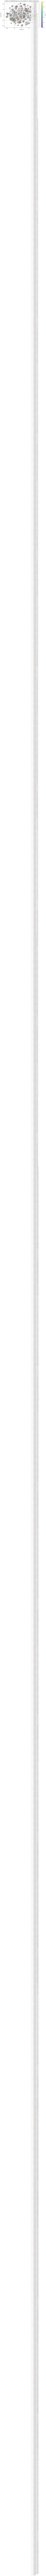

eps  min_samples  Silhouette Score  Davies-Bouldin Score  \
0  0.5            3          0.640569              0.386668   
1  0.7            3          0.519328              0.464968   

   Calinski-Harabasz Score  ruido_percent  clusters_validos  Score Geral  
0            140718.953125          21.24              2207      3.00000  
1             52141.691406          10.89              1720      2.01287

In [17]:
resultado_dbscan = processar_dbscan_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings4_TSNE', eps_values = [0.5, 0.7], min_samples_values = [3])

# Exibir os resultados
resultado_dbscan.head(100)

#### 2.2.4) Redução com PCA + t-SNE

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings4_PCA_TSNE', k_min=2, k_max=10, sufixo_grafico="PCA + t-SNE")

# Exibir os resultados
resultado_kmeans.head(100)

#### 2.2.5) Redução com UMAP

In [ ]:
resultado_kmeans = processar_kmeans_e_clusterizar(df_portarias_mgi, 'SBERT_Embeddings4_UMAP', k_min=2, k_max=10, sufixo_grafico="UMAP")

# Exibir os resultados
resultado_kmeans.head(100)